In [1]:
import os
import io
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
import data

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
class MNIST(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        try:
            row = self.dataframe.iloc[index]
            imgBytes = row['image']['bytes']
            image = Image.open(io.BytesIO(imgBytes)).convert('L')

            imageNp = np.array(image, dtype=np.float32).reshape(28, 28)
            paddedImage = np.zeros((32, 32), dtype=np.float32)
            paddedImage[2:30, 2:30] = imageNp
            normalizedImage = (paddedImage / 127.5) - 1.0

            inputTensor = torch.from_numpy(normalizedImage).unsqueeze(0)
            label = int(row['label'])

            return inputTensor, label
        except Exception as e:
            print(f"Error at index {index}: {e}")
            raise e



In [4]:
def loadDatasets():
    print("Loading MNIST")
    trainingData = data.df_train
    testingData = data.df_test
    print("data loaded")
    return trainingData, testingData

trainingData, testingData = loadDatasets()
trainDataset = MNIST(trainingData)
testDataset = MNIST(testingData)

trainLoader = DataLoader(trainDataset, batch_size=32, shuffle=True, num_workers=0)
testLoader = DataLoader(testDataset, batch_size=32, shuffle=False, num_workers=0)

Loading MNIST
data loaded


In [5]:
def generateDigitBitmaps():
    baseTemplates = {
        0: [
            "  ###      ",
            " #   #     ",
            " #   #     ",
            " #   #     ",
            " #   #     ",
            "  ###      ",
            "           "
        ],
        1: [
            "    #      ",
            "   ##      ",
            "    #      ",
            "    #      ",
            "    #      ",
            "    #      ",
            "           "
        ],
        2: [
            "  ###      ",
            " #   #     ",
            "     #     ",
            "   ##      ",
            "  #        ",
            " #####     ",
            "           "
        ],
        3: [
            "  ###      ",
            " #   #     ",
            "     #     ",
            "   ##      ",
            "     #     ",
            " #   #     ",
            "  ###      "
        ],
        4: [
            "    #      ",
            "   ##      ",
            "  # #      ",
            " #  #      ",
            " #####     ",
            "    #      ",
            "    #      "
        ],
        5: [
            " #####     ",
            " #         ",
            " ####      ",
            "     #     ",
            "     #     ",
            " #   #     ",
            "  ###      "
        ],
        6: [
            "  ###      ",
            " #         ",
            " #         ",
            " ####      ",
            " #   #     ",
            " #   #     ",
            "  ###      "
        ],
        7: [
            " #####     ",
            "     #     ",
            "    #      ",
            "    #      ",
            "   #       ",
            "   #       ",
            "           "
        ],
        8: [
            "  ###      ",
            " #   #     ",
            " #   #     ",
            "  ###      ",
            " #   #     ",
            " #   #     ",
            "  ###      "
        ],
        9: [
            "  ###      ",
            " #   #     ",
            " #   #     ",
            "  ####     ",
            "     #     ",
            "     #     ",
            "  ###      "
        ]
    }

    def pad_row(row):
        return row.ljust(12)

    bitmaps = []
    for digit in range(10):
        template = [pad_row(row) for row in baseTemplates[digit]]
        bitmap = [[1 if char == "#" else -1 for char in row] for row in template]
        bitmaps.append(torch.tensor(bitmap, dtype=torch.float32).flatten())

    return torch.stack(bitmaps)


In [6]:
class LeNet5Model(nn.Module):
    def __init__(self):
        super(LeNet5Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5)
        self.fc1 = nn.Linear(120, 84)  

    def forward(self, x):
        x = F.tanh(self.conv1(x))
        x = self.pool1(x)
        x = F.tanh(self.conv2(x))
        x = self.pool2(x)
        x = F.tanh(self.conv3(x))
        x = x.view(-1, 120)
        x = F.tanh(self.fc1(x))  
        return x

In [7]:
class StochasticDiagonalLevenbergMarquardt(optim.Optimizer):
    def __init__(self, parameters, lr=0.01, mu=1e-3, eta=1e-2):
        defaults = {'lr': lr, 'mu': mu, 'eta': eta}
        super(StochasticDiagonalLevenbergMarquardt, self).__init__(parameters, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            lr = group['lr']
            mu = group['mu']
            for param in group['params']:
                if param.grad is None:
                    continue
                grad = param.grad.data
                state = self.state[param]
                if 'hessianDiag' not in state:
                    state['hessianDiag'] = torch.zeros_like(param.data)
                hessianDiag = state['hessianDiag']
                hessianDiag.add_(grad ** 2)
                adaptiveLr = lr / (mu + hessianDiag.sqrt())
                param.data -= adaptiveLr * grad

        return loss

In [8]:
class MAPLossFunction(nn.Module):
    """
    Implementation of Maximum A Posteriori (MAP) loss.
    """
    def __init__(self, j: float = 0.1):
        super(MAPLossFunction, self).__init__()
        self.j = j

    def forward(self, outputs, targets):
        penalties = F.log_softmax(-outputs, dim=1)
        correctClassPenalty = penalties[range(len(targets)), targets]
        expOtherClasses = torch.exp(-penalties).sum(dim=1)
        jTensor = torch.tensor(self.j, device=outputs.device)  
        competitivePenalty = torch.log(torch.exp(-jTensor) + expOtherClasses)
        mapLoss = correctClassPenalty + competitivePenalty
        return mapLoss.mean()

In [9]:
def evaluateRbf(model, loader, targetVectors):
    model.eval()
    total = 0
    correct = 0
    predictions, targets = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            distances = torch.cdist(outputs, targetVectors)
            preds = distances.argmin(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            predictions.append(preds.cpu())
            targets.append(labels.cpu())
    return correct / total, torch.cat(predictions), torch.cat(targets)

In [10]:
def confusionMatrix(predictions, targets):
    """
    Generate a confusion matrix.
    """
    matrix = torch.zeros(10, 10, dtype=torch.int64)
    for prediction, target in zip(predictions, targets):
        matrix[target, prediction] += 1
    return matrix

In [11]:
digitBitmaps = generateDigitBitmaps().to(device)
print(f"shape: {digitBitmaps.shape}") 
targetVectors = digitBitmaps.to(device)

shape: torch.Size([10, 84])


In [12]:
model = LeNet5Model().to(device)

In [13]:
lossFunction = MAPLossFunction(j=0.1)
optimizer = StochasticDiagonalLevenbergMarquardt(model.parameters(), lr=0.01, mu=1e-3, eta=1e-2)

In [14]:
epochs = 20
trainErrors = []
testErrors = []

for epoch in range(1, epochs + 1):
    model.train()
    runningLoss = 0.0

    for inputs, labels in trainLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        predictions = model(inputs)
        distances = torch.cdist(predictions, digitBitmaps)
        loss = lossFunction(-distances, labels)
        loss.backward()
        optimizer.step()
        runningLoss += loss.item() * inputs.size(0)

    trainAccuracy, _, _ = evaluateRbf(model, trainLoader, digitBitmaps)
    testAccuracy, testPredictions, testTargets = evaluateRbf(model, testLoader, digitBitmaps)

    trainErrors.append(1 - trainAccuracy)
    testErrors.append(1 - testAccuracy)

    print(f"Epoch {epoch}, Loss: {runningLoss / len(trainLoader.dataset):.4f}, Train Accuracy: {trainAccuracy:.4f}, Test Accuracy: {testAccuracy:.4f}")

Epoch 1, Loss: 0.3509, Train Accuracy: 0.9600, Test Accuracy: 0.9594
Epoch 2, Loss: 0.1892, Train Accuracy: 0.9722, Test Accuracy: 0.9709
Epoch 3, Loss: 0.1557, Train Accuracy: 0.9769, Test Accuracy: 0.9746
Epoch 4, Loss: 0.1383, Train Accuracy: 0.9798, Test Accuracy: 0.9784
Epoch 5, Loss: 0.1263, Train Accuracy: 0.9816, Test Accuracy: 0.9793
Epoch 6, Loss: 0.1180, Train Accuracy: 0.9835, Test Accuracy: 0.9801
Epoch 7, Loss: 0.1116, Train Accuracy: 0.9842, Test Accuracy: 0.9815
Epoch 8, Loss: 0.1063, Train Accuracy: 0.9855, Test Accuracy: 0.9827
Epoch 9, Loss: 0.1023, Train Accuracy: 0.9862, Test Accuracy: 0.9829
Epoch 10, Loss: 0.0990, Train Accuracy: 0.9872, Test Accuracy: 0.9834
Epoch 11, Loss: 0.0957, Train Accuracy: 0.9879, Test Accuracy: 0.9838
Epoch 12, Loss: 0.0929, Train Accuracy: 0.9882, Test Accuracy: 0.9840
Epoch 13, Loss: 0.0907, Train Accuracy: 0.9892, Test Accuracy: 0.9840
Epoch 14, Loss: 0.0885, Train Accuracy: 0.9890, Test Accuracy: 0.9846
Epoch 15, Loss: 0.0868, Train

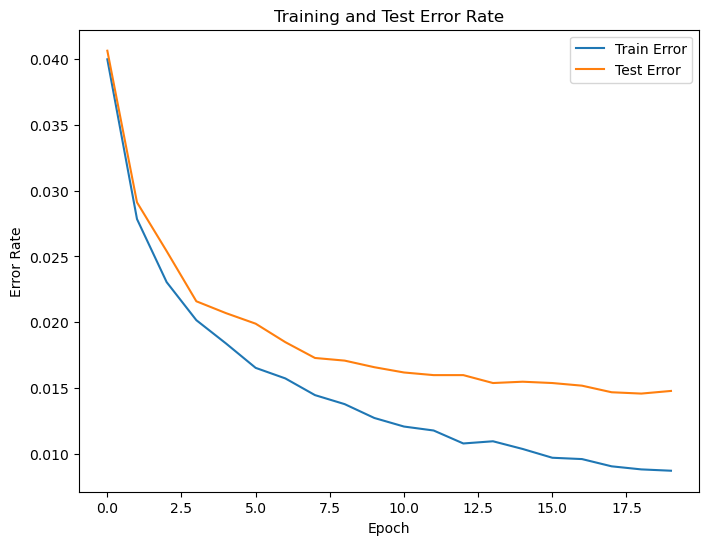

In [15]:
plt.figure(figsize=(8, 6))
plt.plot(trainErrors, label="Train Error")
plt.plot(testErrors, label="Test Error")
plt.xlabel("Epoch")
plt.ylabel("Error Rate")
plt.title("Training and Test Error Rate")
plt.legend()
plt.show()

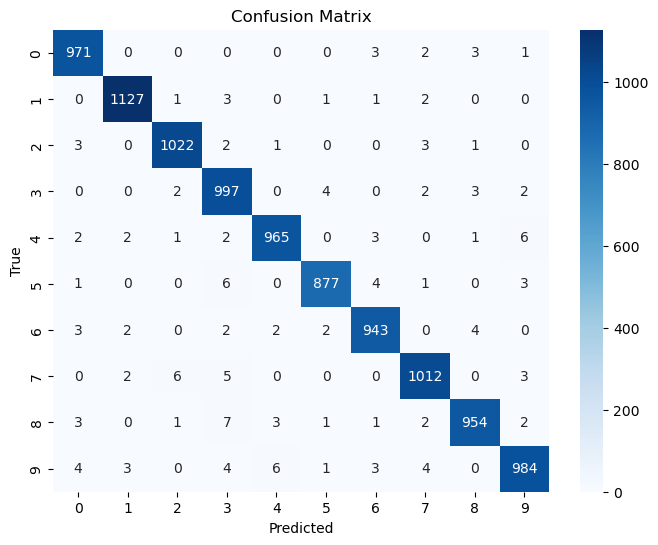

In [16]:
confusionMat = confusionMatrix(testPredictions, testTargets)
plt.figure(figsize=(8, 6))
sns.heatmap(confusionMat.numpy(), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

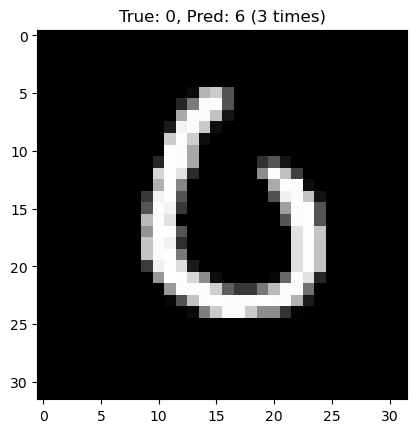

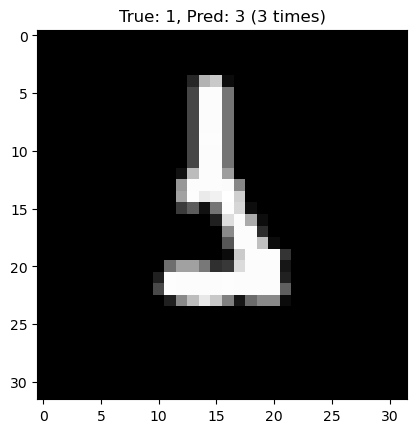

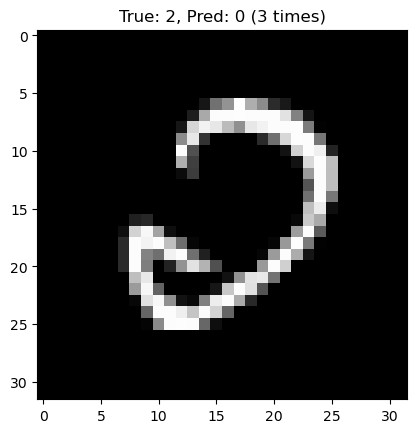

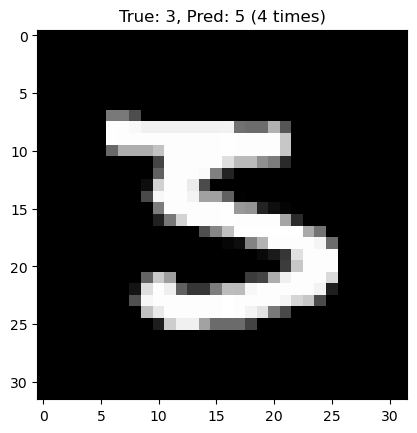

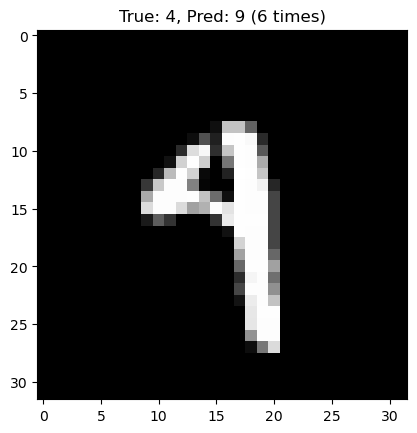

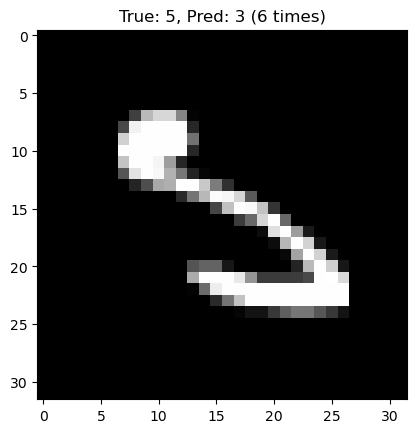

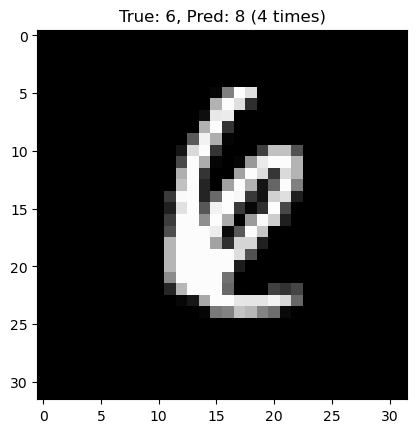

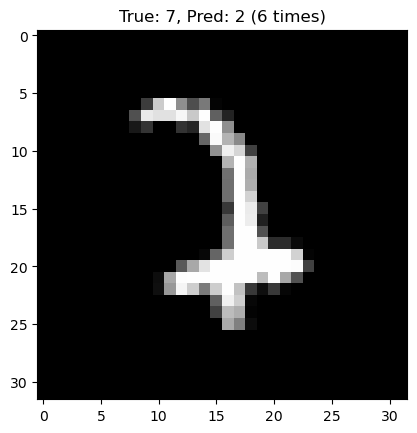

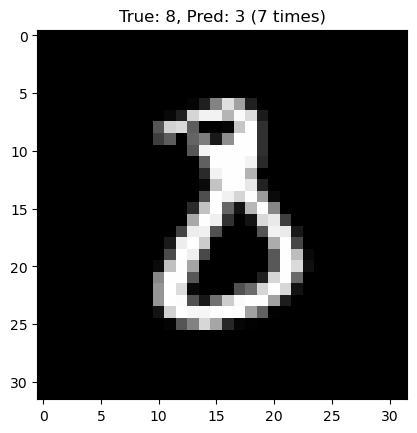

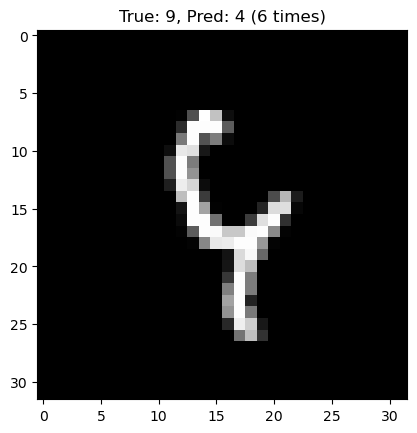

In [17]:
misclassifiedCounts = {i: {j: 0 for j in range(10)} for i in range(10)}
examples = {i: {j: None for j in range(10)} for i in range(10)}

with torch.no_grad():
    for i in range(len(testDataset)):
        inputTensor, label = testDataset[i]
        inputTensor = inputTensor.unsqueeze(0).to(device)

        outputTensor = model(inputTensor)
        distances = torch.cdist(outputTensor, digitBitmaps)

        prediction = max(0, min(distances.argmin(dim=1).item(), 9))

        if prediction != label:
            misclassifiedCounts[label][prediction] += 1
            if examples[label][prediction] is None:
                examples[label][prediction] = inputTensor.cpu()

for trueLabel in range(10):
    maxMisclassified = max(misclassifiedCounts[trueLabel], key=misclassifiedCounts[trueLabel].get)
    count = misclassifiedCounts[trueLabel][maxMisclassified]

    if count == 0:
        print(f"No misclassifications for digit {trueLabel}")
    else:
        example = examples[trueLabel][maxMisclassified]
        plt.imshow(example.squeeze().numpy(), cmap="gray")
        plt.title(f"True: {trueLabel}, Pred: {maxMisclassified} ({count} times)")
        plt.show()